In [1]:
using NeuralNetworkAnalysis, Plots
using NeuralNetworkAnalysis: read_nnet_mat

┌ Info: Precompiling NeuralNetworkAnalysis [73c0b437-a350-4e9b-97ac-9adb151c271b]
└ @ Base loading.jl:1317


In [2]:
CONTROLLERS = Dict{Symbol, Any}()

CTRL_IDX = Dict(1=>:COC, 2=>:DNC, 3=>:DND, 4=>:DES1500,
                       5=>:CL1500, 6=>:SDES1500, 7=>:SCL1500,
                       8=>:SDES2500, 9=>:SCL2500)

path = "/home/mforets/.julia/dev/NeuralNetworkAnalysis/models/VertCAS/"
for i = 1:9    
    file = joinpath(path, "VertCAS_noResp_pra0$(i)_v9_20HU_200.nnet")
    adv = CTRL_IDX[i]
    CONTROLLERS[adv] = read_nnet(file)
end;

In [3]:
keys(CONTROLLERS)

KeySet for a Dict{Symbol, Any} with 9 entries. Keys:
  :DND
  :SCL1500
  :SDES1500
  :SCL2500
  :SDES2500
  :DES1500
  :CL1500
  :COC
  :DNC

In [4]:
g = 32.2 # gravitational constant

#=
a = [[-g/8, 0, g/8],
      [-g/3, -7g/24, g/4],
      [g/4, 7g/24, g/3],
      [-g/3, -7g/24, -g/4],
      [g/4, 7g/24, g/3],
      [-g/3],
      [g/3],
      [-g/3],
      [g/3]]
=#

# accelerations (middle)
const ACC_MIDDLE = Dict(:COC => 0.0, :DNC => -7g/24, :DND => 7g/24,
                        :DES1500 => -7g/24, :CL1500 => 7g/24, :SDES1500 => -g/3,
                        :SCL1500 => g/3, :SDES2500 => -g/3, :SCL2500 => g/3)

# small (h, hdot0) model
const Δτ = 1.0
const A = [1  -Δτ; 0  1.]

2×2 Matrix{Float64}:
 1.0  -1.0
 0.0   1.0

In [5]:
struct State{T, N}
    state::T # state for (h, hdot0) variables
    τ::N
    adv::Symbol
end

In [6]:
ADVISORIES = Dict{Symbol, Any}()

# for every advisory, return a function to check
# whether the current climbrate complies with the advisory or not
# if the advisory *does not* comply => it is changed according to the ACC dictionary
# otherwise, the new acceleration is zero
using Symbolics
@variables x

ADVISORIES[:COC] = EmptySet(1)
ADVISORIES[:DNC] = HalfSpace(x <= 0)
ADVISORIES[:DND] = HalfSpace(x >= 0)
ADVISORIES[:DES1500] = HalfSpace(x <= -1500)
ADVISORIES[:CL1500] = HalfSpace(x >= 1500)
ADVISORIES[:SDES1500] = HalfSpace(x <= -1500)
ADVISORIES[:SCL1500] = HalfSpace(x >= 1500)
ADVISORIES[:SDES2500] = HalfSpace(x <= -2500)
ADVISORIES[:SCL2500] = HalfSpace(x >= 2500)

# this function receives X = [h, hdot0, τ, adv′] and the
# *previous* advisory adv
function get_acceleration(X::State, adv; ACC=ACC_MIDDLE)
    
    # obtain projection on hdot
    hdot = _interval(X.state, 2)
        
    # transform units
    hdot = 60 * hdot

    # new advisory
    adv′ = X.adv 
    
    # check whether the current state complies with the advisory
    comply = hdot ⊆ ADVISORIES[adv′]

    if adv == adv′ && comply
        return 0.0
    else
        return ACC[adv′]
    end
end

get_acceleration (generic function with 1 method)

In [7]:
# scalar case; alg is ignored
function forward_adv(X::Singleton, τ, adv; alg=nothing)
    v = vcat(element(X), τ*1.0)
    u = forward(CONTROLLERS[adv], v)
    imax = argmax(u)
    return CTRL_IDX[imax]
end

# set-based case
function forward_adv(X::AbstractZonotope, τ, adv; alg=Ai2())
    Y = cartesian_product(X, Singleton([τ*1.0]))
    
    out = forward_network(alg, CONTROLLERS[adv], Y)
    
    outBox = box_approximation(out)
    imax = argmax(high(outBox))
    return CTRL_IDX[imax]
end

forward_adv (generic function with 2 methods)

In [8]:
function VCAS!(out::Vector{State{T, N}}, KMAX; ACC=ACC_MIDDLE, alg_nn=Ai2()) where {T, N}

    # unpack initial state
    X0 = first(out)
    S = X0.state
    τ = X0.τ
    adv = X0.adv

    # get initial acceleration
    hddot = ACC[adv]

    for i in 1:KMAX
        # compute next state
        b = [-hddot*Δτ^2 / 2, hddot * Δτ]
        S′ = affine_map(A, S, b)
        τ′ = τ - 1
        adv′ = forward_adv(S′, τ′, adv, alg=alg_nn)

        # store new state
        X′ = State(S′, τ′, adv′)
        push!(out, X′)

        # get acceleration from network
        hddot = get_acceleration(X′, adv; ACC=ACC)
        
        # update current state
        S = S′
        τ = τ′
        adv = adv′        
    end
    return out
end

VCAS! (generic function with 1 method)

## Simulation

In [9]:
# ======================
# Simulation
# ======================

function _default_state()
    h0 = Interval(-133, -129) 
    hdot0 = [-19.5,-22.5, -25.5, -28.5]
    x = sample(h0)[1]
    y = hdot0[rand(1:4)]
    τ0 = 25
    adv0 = :COC
    return State(Singleton([x, y]), τ0, adv0)
end

function simulate_VCAS(X0::State=_default_state(); KMAX=10)
    out = [X0]
    sizehint!(out, KMAX+1)

    VCAS!(out, KMAX, ACC=ACC_MIDDLE)
    return out
end

simulate_VCAS (generic function with 2 methods)

In [10]:
# project onto the h variable
function _project(X::Vector{State{T, N}}) where {T<:Singleton, N}
    return [Singleton([Xi.state.element[1], Xi.τ*1.0]) for Xi in X]
end

_interval(X::LazySet, i) = overapproximate(Projection(X, (i,)), Interval)

function _project(X::Vector{State{T, N}}) where {T<:Zonotope, N}
    Xint = [_interval(Xi.state, 1) × Singleton([Xi.τ*1.0]) for Xi in X]
end

_project (generic function with 2 methods)

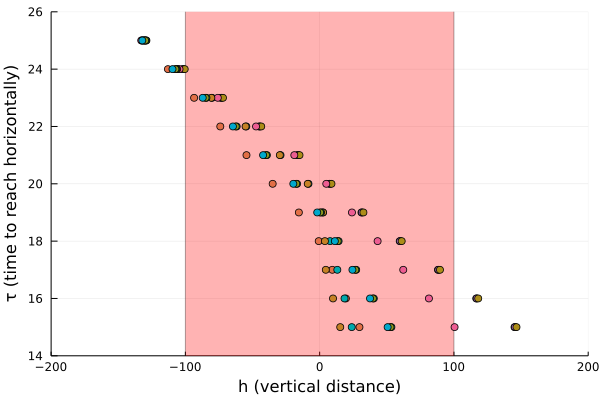

In [11]:
ensemble = [simulate_VCAS() for _ in 1:10];

out = _project.(ensemble)

bad_states = HalfSpace([1.0, 0.0], 100.) ∩ HalfSpace([-1.0, 0.0], 100.)

fig = plot(ylab="τ (time to reach horizontally)", xlab="h (vertical distance)")
plot!(fig, bad_states, xlims=(-200, 200), ylims=(14, 26), alpha=0.3, c=:red)
for o in out
    plot!(fig, o, alpha=1.)
end
fig

## Flowpipe results for one choice of velocity

In [12]:
h0 = Interval(-133, -129) 
hdot0 = [-19.5,-22.5, -25.5, -28.5]
S0 = convert(Zonotope, concretize(h0 × Singleton([hdot0[1]])))

τ0 = 25
adv0 = :COC
X0 = State(S0, τ0, adv0)

result = simulate_VCAS(X0);

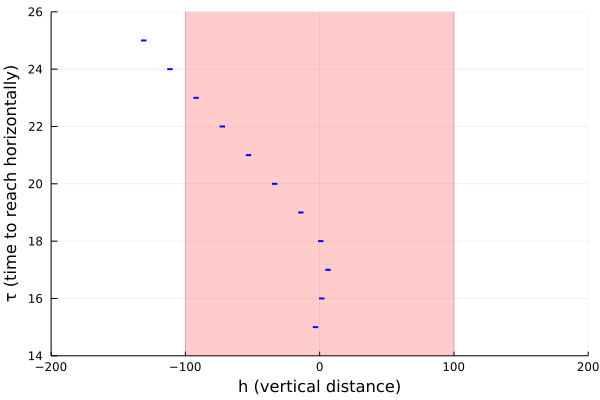

In [13]:
out = _project(result);

bad_states = HalfSpace([1.0, 0.0], 100.) ∩ HalfSpace([-1.0, 0.0], 100.)

fig = plot(ylab="τ (time to reach horizontally)", xlab="h (vertical distance)")
plot!(fig, bad_states, xlims=(-200, 200), ylims=(14, 26), alpha=0.2, c=:red)
for o in out
    plot!(fig, o, lw=2.0, alpha=1., markershape=:none, seriestype=:shape, c=:blue)
end
fig

## Flowpipe resut for all choices of velocity

In [14]:
h0 = Interval(-133, -129) 
hdot0 = [-19.5,-22.5, -25.5, -28.5]

S0 = [convert(Zonotope, concretize(h0 × Singleton([hdot0[i]]))) for i in 1:4]

τ0 = 25
adv0 = :COC
X0 = [State(S0i, τ0, adv0) for S0i in S0]

result = [simulate_VCAS(X0i) for X0i in X0];

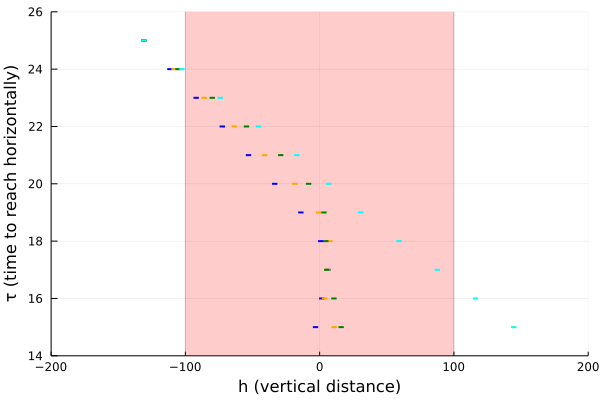

In [15]:
out = _project.(result);

bad_states = HalfSpace([1.0, 0.0], 100.) ∩ HalfSpace([-1.0, 0.0], 100.)

fig = plot(ylab="τ (time to reach horizontally)", xlab="h (vertical distance)")
plot!(fig, bad_states, xlims=(-200, 200), ylims=(14, 26), alpha=0.2, c=:red)
[plot!(fig, o, lw=2.0, alpha=1., markershape=:none, seriestype=:shape, c=:blue) for o in out[1]]
[plot!(fig, o, lw=2.0, alpha=1., markershape=:none, seriestype=:shape, c=:orange) for o in out[2]]
[plot!(fig, o, lw=2.0, alpha=1., markershape=:none, seriestype=:shape, c=:green) for o in out[3]]
[plot!(fig, o, lw=2.0, alpha=1., markershape=:none, seriestype=:shape, c=:cyan) for o in out[4]]
fig